**THIS NOTEBOOK CONTAINS APPLICATION OF SARIMA MODEL FOR SELLER 5 FORM SELLS DATA AND SELLER 23 FORM INVOICE DATA BY FINDIG THE BEST MODEL BY TRAIN TEST APPROACH.**

**Below is importing the requisite libraries for the notebook.**

In [347]:
#Importing the prerequisite libraries that are to be used further.
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib.pyplot as plt

**Importing the sales and invoice data.**

In [348]:
sales=pd.read_csv("sales_receipt.csv")
invoice=pd.read_csv("inv_transdt_transamt_selrid.csv")

**Preparing the data by formating date.**

In [349]:
sales["TransactionDate"]=pd.to_datetime(pd.to_datetime(sales.TransactionDate).dt.date)
invoice["TransactionDate"]=pd.to_datetime(pd.to_datetime(invoice.TransactionDate).dt.date)

**Extracting needed variables from the dataframes.**

In [350]:
invoice.groupby("SellerId").Trans_amount.count()

SellerId
1         8
2       631
3        97
5      1790
6        32
9      2898
10    20803
11     4118
12     7946
13      654
14     2676
15     4575
16      967
17      556
18     1990
19        2
20     2316
21    25065
22     1035
23     4663
24       51
25     2439
26      321
27      454
28      232
Name: Trans_amount, dtype: int64

In [351]:
sales_fin=sales[["TransactionDate","SellerId", "Amount"]]
invoice_fin=invoice[["TransactionDate","SellerId", "Trans_amount"]]

<font color="red"> **SARIMA MODEL FOR SELLS DATA FOR SELLER 5 WHICH IS A SEASONAL DATA.**</font>

**Data extraction for seller 5 and preparing the time series.**

In [352]:
data=sales_fin[sales_fin["SellerId"]==5][["TransactionDate","Amount"]]
data=data.set_index("TransactionDate")
data=data.groupby(pd.Grouper(freq="W")).sum()
ts=data["Amount"]
ts=ts.apply(lambda x: int(x))

In [353]:
len(ts)

186

**Below plot shows that the data is seasonal.**

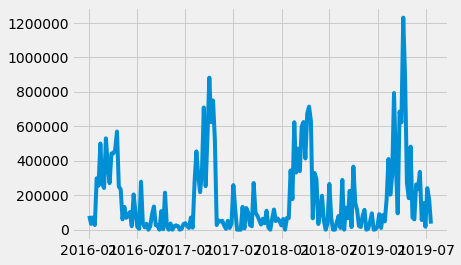

In [354]:
plt.plot(ts)

<font color="red"> **TRAIN TEST APPROACH TO FIND THE BEST SPLIT**</font>

**Below function is to connect the first index of predicted value with last index of the time series.**

In [355]:
def pred_fina(predicted, train):
    c=pd.Index(predicted.index)
    c=c.insert(0, pd.to_datetime(train.index[-1]))
    lis=list(predicted.values)
    lis.insert(0,train[-1])
    lis=pd.Series(lis,index=c)
    prediction_final=lis.apply(lambda x:int(x))
    return prediction_final

**Below code is all about spliting the time series at different reatios, fitting the model at train set, predicting on the test set, finding the aic for different ratios.**

In [356]:
from statsmodels.tsa.stattools import adfuller
def dft(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test_stats','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

In [357]:
dft(ts)

Test_stats                      -3.744430
p-value                          0.003530
#Lags Used                       2.000000
Number of Observations Used    183.000000
Critical Value (1%)             -3.466598
Critical Value (5%)             -2.877467
Critical Value (10%)            -2.575260
dtype: float64

**Output shows that data is not stationary so we need to apply differencing.**

**Below code contains training of SARIMA model at different ratio of data in train set and also calculates corresponding aic value for the model.**

In [358]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#An empty list to store mean squared error.
rmse=[]
#An empty list to store aic.
aic=[]
# An empty list storing fraction of total data present in training set.
ratio=[]
for x in np.arange(0.6,0.95,0.005):
    #size of training set.
    train_size = int(len(ts)*x)
    #splitting the data.    
    train, test = ts[0:train_size], ts[train_size:len(ts)]
    train_diff=train-train.shift()
    train_diff=train_diff.dropna()
    if dft(train_diff)[0]<dft(train_diff)[4]:
        model = SARIMAX(train_diff, order=(1,0,1), seasonal_order=(1,0,1,2))
        model_fit = model.fit(disp=False)
        prediction_final= model_fit.predict(test.index[0], test.index[-1])
        predict=pred_fina(prediction_final, train)
        pred_fin=predict.cumsum()
        aic.append(model_fit.aic)
        rmse.append(np.sqrt(np.mean((-test+pred_fin)**2)))
        ratio.append(x)     

**Preparation a dataframe of ratio and aic value.**

In [359]:
ratio_aic=pd.DataFrame()
ratio_aic["ratio"]=ratio
ratio_aic["aic"]=aic

**Below code shows the variation of aic with ratio.**

In [360]:
ratio_aic

,ratio,aic
0,0.600,2910.331895
1,0.605,2953.647851
2,0.610,2979.913804
3,0.615,3005.749038
4,0.620,3031.641539
5,0.625,3061.198842
6,0.630,3087.495642
7,0.635,3110.799046
8,0.640,3137.386658
9,0.645,3137.386658


**Plotting the aic against ratio.**

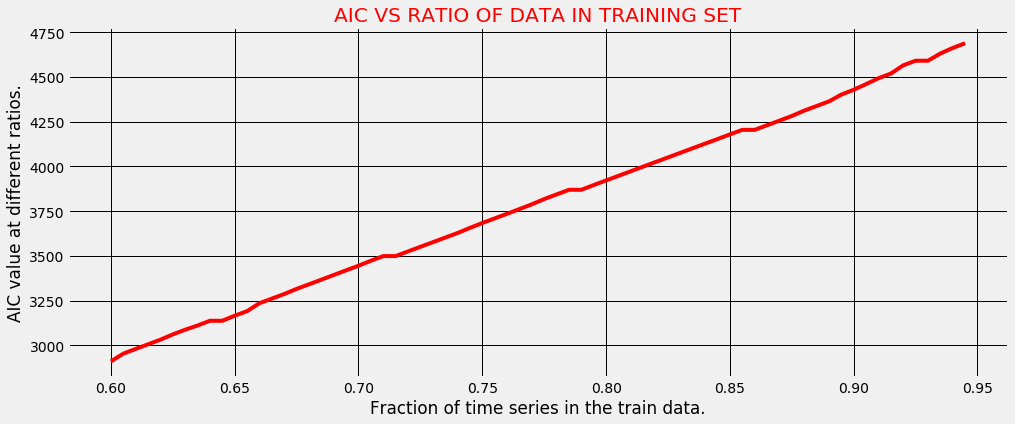

In [361]:
plt.figure(figsize=(15,6))
plt.plot(ratio_aic.ratio, ratio_aic.aic, color="red")
plt.xlabel("Fraction of time series in the train data.")
plt.ylabel("AIC value at different ratios.")
plt.title("AIC VS RATIO OF DATA IN TRAINING SET", color="red")
plt.grid(True, color="black")
plt.show()

**From above plot 0.675 is the best split to continue with for modeling.**

**Creating the train test data at the best ratio.**

In [362]:
train_size = int(len(ts)*0.675)   
train, test = ts[0:train_size], ts[train_size:len(ts)]
train_diff=train-train.shift()
train_diff=train_diff.dropna()

**Below are the steps to find the order of the model.**

In [363]:
from statsmodels.tsa.stattools import acf, pacf
# Requisite libraries for computing auto correlation function and partial auto correlation function. 
lag_acf = acf(train_diff, nlags=6)
lag_pacf = pacf(train_diff, nlags=8, method='ols')
#ols stands for ordinary least squared.

Text(0.5, 1.0, 'Autocorrelation Function')

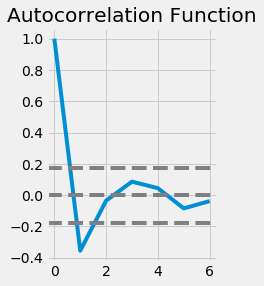

In [364]:
#This is the plotting of acf.
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

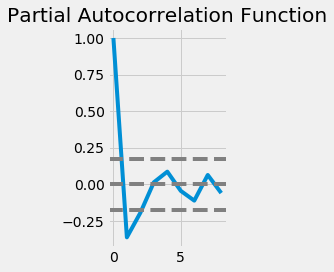

In [365]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [366]:
test.tail()

TransactionDate
2019-06-23    154500
2019-06-30     17500
2019-07-07    241000
2019-07-14    177750
2019-07-21     35000
Freq: W-SUN, Name: Amount, dtype: int64

In [367]:
train.tail()

TransactionDate
2018-04-22    630300
2018-04-29     66000
2018-05-06    328876
2018-05-13    291400
2018-05-20     33000
Freq: W-SUN, Name: Amount, dtype: int64

**Below is code to run the SARIMA Model on the data.**

In [368]:
model = SARIMAX(train_diff, order=(1,1,1),seasonal_order=(1,1,1,22))
model_fit = model.fit(disp=False)
prediction_final= model_fit.predict("2018-05-27", "2019-07-21")
predict=pred_fina(prediction_final, train)
pred_fin=predict.cumsum()

In [369]:
predict=np.exp(pred_fin)

In [370]:
model_fit.aic

2752.758614876841

In [371]:
model_fit.bic

2765.834217461047

**This is the final prediction**

**Following plot shows the variation of forecasted value and the whole time series.**

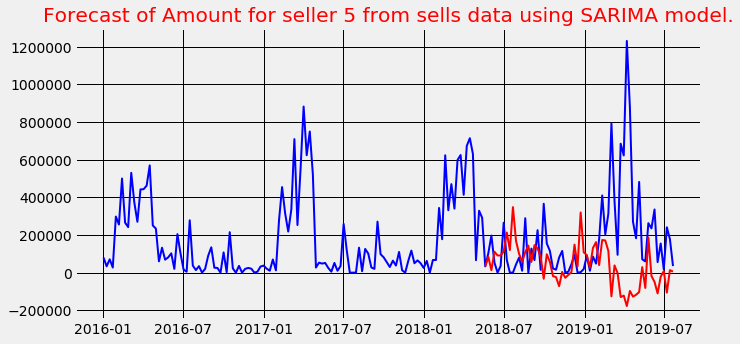

In [372]:
plt.figure(figsize=(10,5))
plt.plot(ts, color="blue", linewidth=2)
plt.plot(pred_fin, color="red", linewidth=2)
plt.title("Forecast of Amount for seller 5 from sells data using SARIMA model.", color="red")
plt.grid(True, color="black")
plt.show()

<font color="red"> **SARIMA MODEL FOR INVOICES DATA FOR SELLER ID 23.**</font>

**Train test approach**

**Data preparation stage**

In [373]:
data=invoice_fin[invoice_fin["SellerId"]==23][["TransactionDate","Trans_amount"]]
data=data.set_index("TransactionDate")
data=data.groupby(pd.Grouper(freq="W")).sum()
ts=data["Trans_amount"]
ts=ts.apply(lambda x: int(x))

In [374]:
len(ts)

154

**Testing the stationary of the data.**

In [375]:
dft(ts)

Test_stats                    -1.096623e+01
p-value                        8.090574e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.530000e+02
Critical Value (1%)           -3.473830e+00
Critical Value (5%)           -2.880623e+00
Critical Value (10%)          -2.576945e+00
dtype: float64

**The data is stationary and hence no need of any transformation and differencing.**

**Below is the connecter function to connect the first index of predicted series and last of the training series.**

In [376]:
def xyz(predicted, train):
    c=pd.Index(predicted.index)
    c=c.insert(0, pd.to_datetime(train.index[-1]))
    lis=list(predicted.values)
    lis.insert(0,train[-1])
    lis=pd.Series(lis,index=c)
    prediction_final=lis.apply(lambda x:int(x))
    return prediction_final

**Importing requisite libraries for finding the order of sarima model.**

In [377]:
from statsmodels.tsa.stattools import acf, pacf
# Requisite libraries for computing auto correlation function and partial auto correlation function. 
lag_acf = acf(ts, nlags=5)
lag_pacf = pacf(ts, nlags=8, method='ols')
#ols stands for ordinary least squared.

**ACF plot to know q value**

Text(0.5, 1.0, 'Autocorrelation Function')

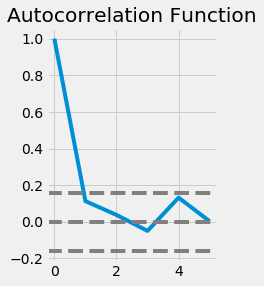

In [378]:
#This is the plotting of acf.
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

**PACF plot to get p value.**

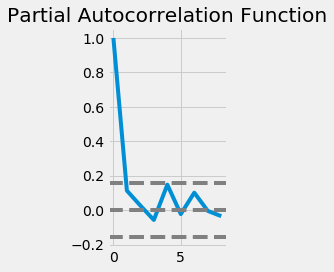

In [379]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**Below code contains the trial of different SARIMA models at different fraction of data in the train set. It also contains the computation of aic values of models prepared at different ratios.**

In [380]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#An empty list to store mean squared error.
rmse=[]
#An empty list to store aic.
aic=[]
# An empty list storing fraction of total data present in training set.
ratio=[]
for x in np.arange(0.6,0.95,0.005):
    #size of training set.
    train_size = int(len(ts)*x)
    #splitting the data.    
    train, test = ts[0:train_size], ts[train_size:len(ts)]
    train_diff=train-train.shift()
    train_diff=train_diff.dropna()
    if dft(train_diff)[0]<dft(train_diff)[4]:
        model = SARIMAX(train_diff, order=(2,1,0), seasonal_order=(1,0,0,2))
        model_fit = model.fit(disp=False)
        prediction_final= model_fit.predict(test.index[0], test.index[-1])
        predict=xyz(prediction_final, train)
        predict=predict.cumsum()
        aic.append(model_fit.aic)
        rmse.append(np.sqrt(np.mean((-test+pred_fin)**2)))
        ratio.append(x)     

**Below code is to create the dataframe of ratio and aic values to find the best model.**

In [381]:
aic_ratio=pd.DataFrame()
aic_ratio["ratio"]=ratio
aic_ratio["aic"]=aic

**Plotting aic against ratio.**

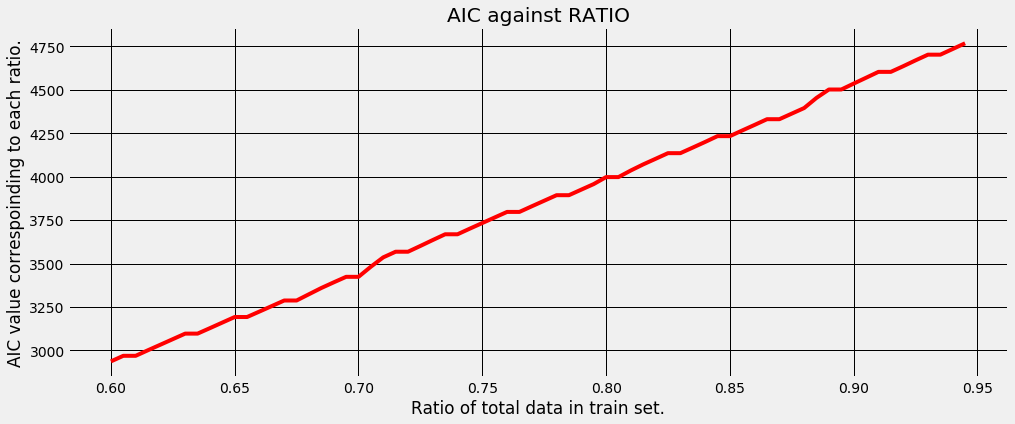

In [382]:
plt.figure(figsize=(15,6))
plt.plot(aic_ratio.ratio, aic_ratio.aic, color="red")
plt.xlabel("Ratio of total data in train set.")
plt.ylabel("AIC value correspoinding to each ratio.")
plt.title("AIC against RATIO")
plt.grid(True, color="black")
plt.show()

**From above code the best ratio value is 0.675.**

In [383]:
data=invoice_fin[invoice_fin["SellerId"]==23][["TransactionDate","Trans_amount"]]
data=data.set_index("TransactionDate")
data=data.groupby(pd.Grouper(freq="W")).sum()
ts=data["Trans_amount"]
ts=ts[:-1]

In [384]:
len(ts)

153

**Preparing the data.**

In [385]:
train_size = int(len(ts)*0.675)    
train, test = ts[0:train_size], ts[train_size:len(ts)]

**Sample of time series.**

In [386]:
dft(train)

Test_stats                    -7.121817e+00
p-value                        3.705667e-10
#Lags Used                     1.000000e+00
Number of Observations Used    1.010000e+02
Critical Value (1%)           -3.496818e+00
Critical Value (5%)           -2.890611e+00
Critical Value (10%)          -2.582277e+00
dtype: float64

In [387]:
test.tail()

TransactionDate
2019-09-01    0
2019-09-08    0
2019-09-15    0
2019-09-22    0
2019-09-29    0
Freq: W-SUN, Name: Trans_amount, dtype: int64

**preparing the model with requisite order.**

In [388]:
model = SARIMAX(train_diff, order=(1,1,0), seasonal_order=(1,1,0,52))

**Fitting the model.**

In [389]:
model_fit = model.fit(disp=False)

In [390]:
model_fit.aic

3102.2752071194122

In [391]:
model_fit.bic

3109.8077856389627

In [392]:
test.tail()

TransactionDate
2019-09-01    0
2019-09-08    0
2019-09-15    0
2019-09-22    0
2019-09-29    0
Freq: W-SUN, Name: Trans_amount, dtype: int64

In [393]:
prediction_final= model_fit.predict("2018-10-14","2019-08-11")

**Predicting the outcome for test set.**

In [394]:
#prediction_final= model_fit.predict(test.index[0], test.index[-1])

**Below is the connection of predicted value with the time series to make the plot continuous.**

In [395]:
predict=xyz(prediction_final, train)

**This is the reverse transformation stage.**

In [396]:
predict=predict.cumsum()

**Following plot shows the forecasted value for test set in red color and whole series in blue color.**

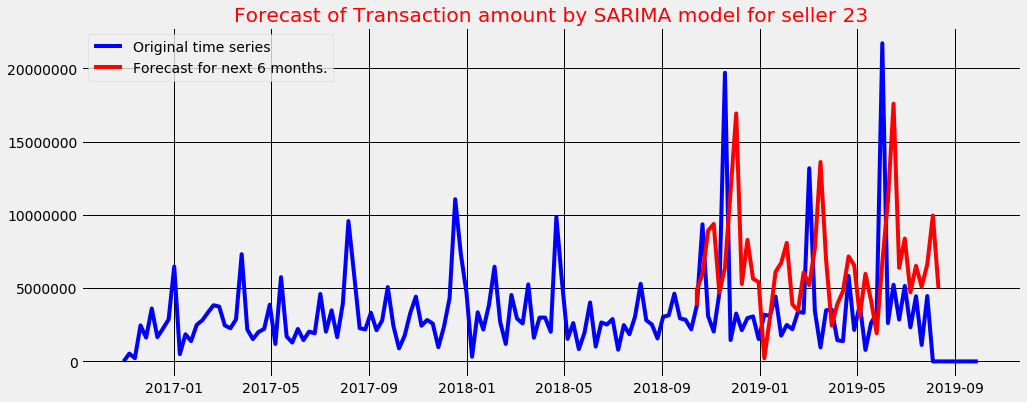

In [397]:
plt.figure(figsize=(15,6))
plt.plot(ts, color="blue", label="Original time series")
plt.plot(predict, color="red", label="Forecast for next 6 months.")
plt.title("Forecast of Transaction amount by SARIMA model for seller 23", color="red")
plt.legend(loc="best")
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid(True, color="black")
plt.show()